In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential


from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.visualization.plot_data import matrix_heatmap

from sklearn.metrics import pairwise_distances
np.set_printoptions(precision=2, suppress=True)

Using TensorFlow backend.


#  Import network from file

In [4]:
import pickle

# READ
with open('moge/data/LMN_only_directed/lmn_miRTarBase_edges10/lmn_miRTarBase_edges10_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.node_list.extend(network_test.node_list)
    network.process_genes_info()
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

with open('moge/data/LMN_only_directed/lmn_miRTarBase_edges10/lmn_miRTarBase_edges10_val.pickle', 'rb') as file:
    network_test = pickle.load(file)
    network_test.process_genes_info()

Genes info columns: ['Family', 'Transcript sequence', 'location', 'Disease association', 'locus_type', 'Transcript length']
Number of nodes without seq removed: -11700
Total nodes (filtered): 20607
Genes info columns: ['Family', 'Transcript sequence', 'location', 'Disease association', 'locus_type', 'Transcript length']
Number of nodes without seq removed: 0
Total nodes (filtered): 32307


# Data Generator

In [6]:
from moge.network.data_generator import DataGenerator

generator = DataGenerator(network=network, negative_sampling_ratio=2.0,
                          maxlen=1400, padding='post', truncating="post",
                          batch_size=1, sequence_to_matrix=False,
                          shuffle=True, seed=0)
generator.genes_info = generator.genes_info[generator.genes_info["Transcript sequence"].notna()]

X, y = generator.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Ed_count: 346200 , Eu_count: 62751 , En_count: 246253
Ens_count: 692400
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
X: [('input_seq_j', (1, 1400)), ('input_seq_i', (1, 1400)), ('is_directed', (1, 1))] 
y: (1, 1)


# Load saved model to Siamese Graph Embedding

In [7]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
siamese = SiameseGraphEmbedding(d=128, batch_size=1, lr=0.001, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=1400, truncating="post", verbose=True)
siamese.load_model("moge/data/LMN_only_directed/models/lstm_128_LNCnode10_train_trunc700_MASKING_e10.h5",
                  generator)
siamese.subsample = False

Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:GPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:GPU:0)
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Network total weights: 3557179
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
siamese.save_embeddings("moge/data/LMN_only_directed/emb/lmn_LNC_nodes10_train.siamese_masking.emb", 
                        variable_length=True)


In [6]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_only_directed/emb/lmn_miRTarBase_edges10_train.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_only_directed/emb/lmn_miRTarBase_edges10_train.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_only_directed/emb/lmn_miRTarBase_edges10_train.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_only_directed/emb/lmn_miRTarBase_edges10_train.sdne.emb", 
                          node_list=network.node_list)

rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_only_directed/emb/lmn_miRTarBase_edges10_train.siamese_masking.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20420, 128)
LINE imported (18727, 128)
HOPE imported (20420, 128)
SDNE imported (20394, 128)
rna2rna imported (20607, 128)



In [7]:
# Select method
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
# methods["rna2rna"] = siamese

# Top-K Link Prediction

In [9]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_test, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

Embeddings filtered by node list (30023, 128)


{'precision': 0.0002, 'recall': 6.249023590064053e-05}

# Clustering Result

In [8]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", n_clusters=None))

node2vec
{'homogeneity': 0.6803794855339146, 'completeness': 0.6039826108325207, 'nmi': 0.6399089153942431}
LINE
{'homogeneity': 0.7058588512277532, 'completeness': 0.623334292765871, 'nmi': 0.6620347536560754}
HOPE
{'homogeneity': 0.5265236322799977, 'completeness': 0.5603621135395974, 'nmi': 0.5429161189163992}
SDNE
{'homogeneity': 0.5801139542404669, 'completeness': 0.5534771549147431, 'nmi': 0.5664826026355032}
rna2rna
{'homogeneity': 0.6691843733124039, 'completeness': 0.5660307272617989, 'nmi': 0.6133003350139934}


# Node Classification

In [36]:
network.genes_info

Family  \
hsa-let-7a-1                                        NaN   
hsa-let-7a-2                      let-7a-2-3p/let-7g-3p   
hsa-let-7a-3                                        NaN   
hsa-let-7b                               let-7-5p/98-5p   
hsa-let-7c                               let-7-5p/98-5p   
hsa-let-7d                               let-7-5p/98-5p   
hsa-let-7e                               let-7-5p/98-5p   
hsa-let-7f-1      let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p   
hsa-let-7f-2                        let-7f-2-3p/1185-3p   
hsa-let-7g                               let-7-5p/98-5p   
hsa-let-7i                               let-7-5p/98-5p   
hsa-mir-1-1                                         NaN   
hsa-mir-1-2                                         NaN   
hsa-mir-100                                  miR-100-3p   
hsa-mir-101-1                                       NaN   
hsa-mir-101-2                                       NaN   
hsa-mir-103a-1                                      NaN   
hsa-mir-103a-2                            miR-103a-2-5p   
hsa-mir-103b-1                                      NaN   
hsa-mir-103b-2                                      NaN   
hsa-mir-105-1                                       NaN   
hsa-mir-105-2                                       NaN   
hsa-mir-106a                                miR-106a-3p   
hsa-mir-106b                                miR-106b-3p   
hsa-mir-107                              miR-103-3p/107   
hsa-mir-10a                                   miR-10-5p   
hsa-mir-10b                                   miR-10-5p   
hsa-mir-1178                                miR-1178-3p   
hsa-mir-1179                                   miR-1179   
hsa-mir-1180                                miR-1180-3p   
...                                                 ...   
AC004067.5                                          NaN   
RP11-166O4.6                                        NaN   
RP11-218F10.3                                       NaN   
RP4-569M23.4                                        NaN   
RP11-797D24.3                                       NaN   
RP11-686O6.2                                        NaN   
RP11-398A8.4                                        NaN   
RP11-313P22.1                                       NaN   
RP13-1039J1.4                                       NaN   
RP11-102N12.3                                       NaN   
LL09NC01-139C3.1                                    NaN   
RP11-295P9.12                                       NaN   
RP11-108L7.14                                       NaN   
RP11-126K1.9                                        NaN   
RP4-671G15.2                                  antisense   
RP11-731C17.2                                       NaN   
RP4-621B10.8                                        NaN   
ENSG00000273488                                     NaN   
AP000230.1                                          NaN   
RP11-80H18.4                                        NaN   
ENSGR0000185203                                     NaN   
ENSGR0000223511                                     NaN   
ENSGR0000223571                                     NaN   
ENSGR0000226179                                     NaN   
ENSGR0000230542                                     NaN   
ENSGR0000234622                                     NaN   
ENSGR0000236017                                     NaN   
ENSGR0000236871                                     NaN   
ENSGR0000237531                                     NaN   
ENSGR0000270726                                     NaN   

                                                Transcript sequence  location  \
hsa-let-7a-1                                                    NaN   9q22.32   
hsa-let-7a-2                                 CUGUACAGCCUCCUAGCUUUCC   11q24.1   
hsa-let-7a-3                                                    NaN  22q13.31   
hsa-let-7b                                   UGAGGUAGUAGGUUGUGUGGU

In [35]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print(method)
    print(evaluate_classification(methods[method], network, cv=5,
                                  node_label="Family", multilabel=False,
                                  scoring=['precision_micro', 'recall_micro', "f1_micro"]))

node2vec


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


ValueError: multiclass format is not supported

# Visualize embedding

Embeddings filtered by node list (30023, 128)


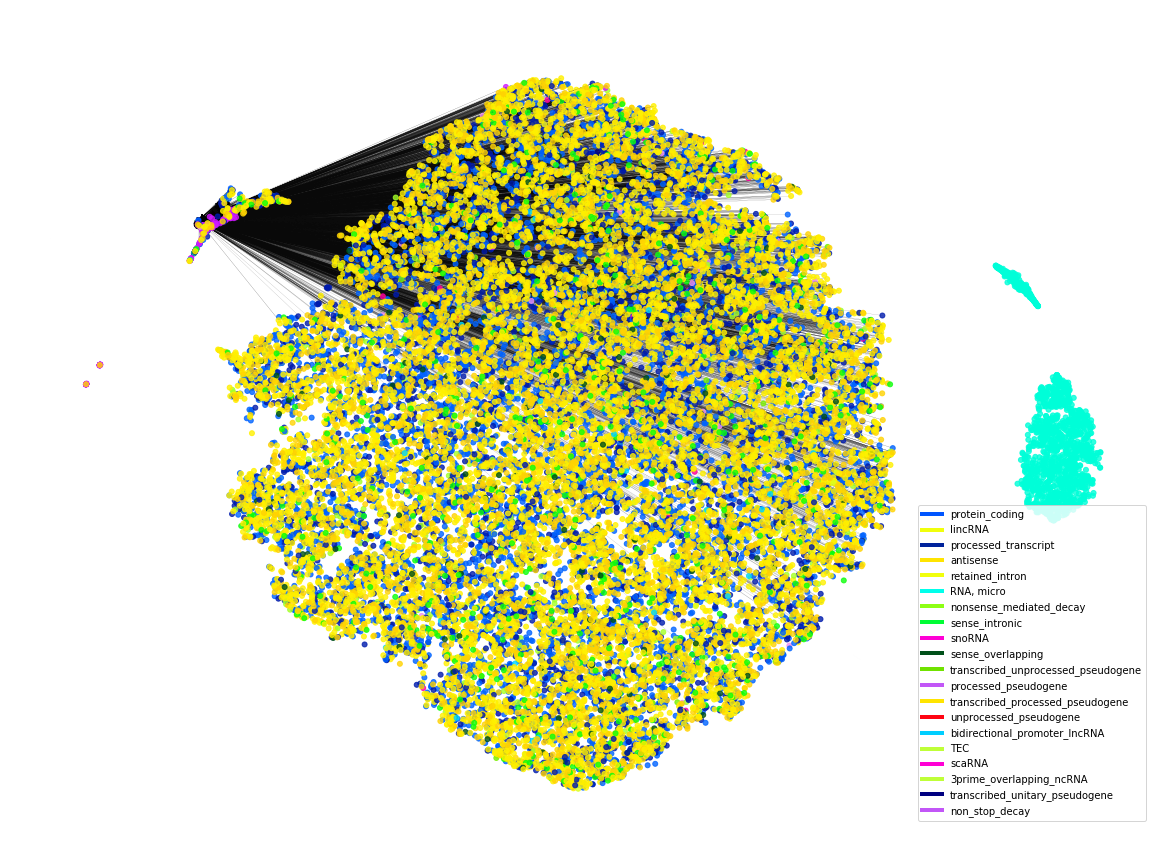

In [11]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(rna2rna_emb, network_train=network, cmap="gist_ncar")

# Visualize Embeddings

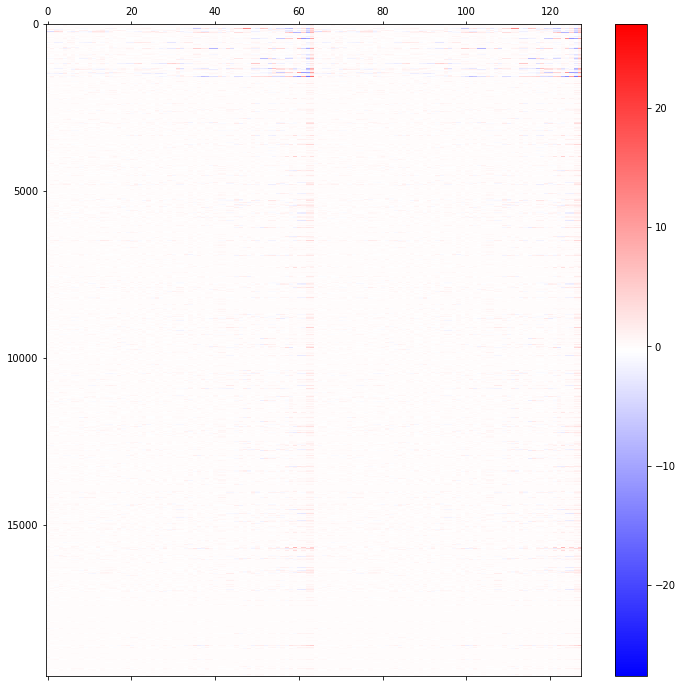

In [174]:
matrix_heatmap(embs, cmap="bwr", aspect='auto')

Embeddings filtered by node list (11769, 512)


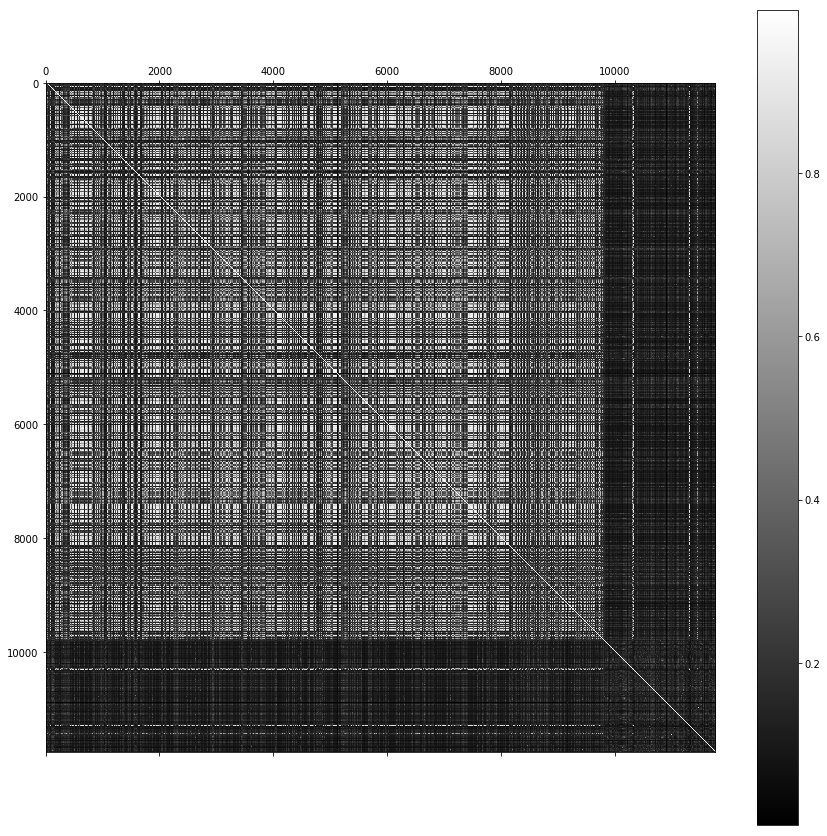

In [9]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", node_l=network.nodes["LNC"]))

Embeddings filtered by node list (32307, 512)


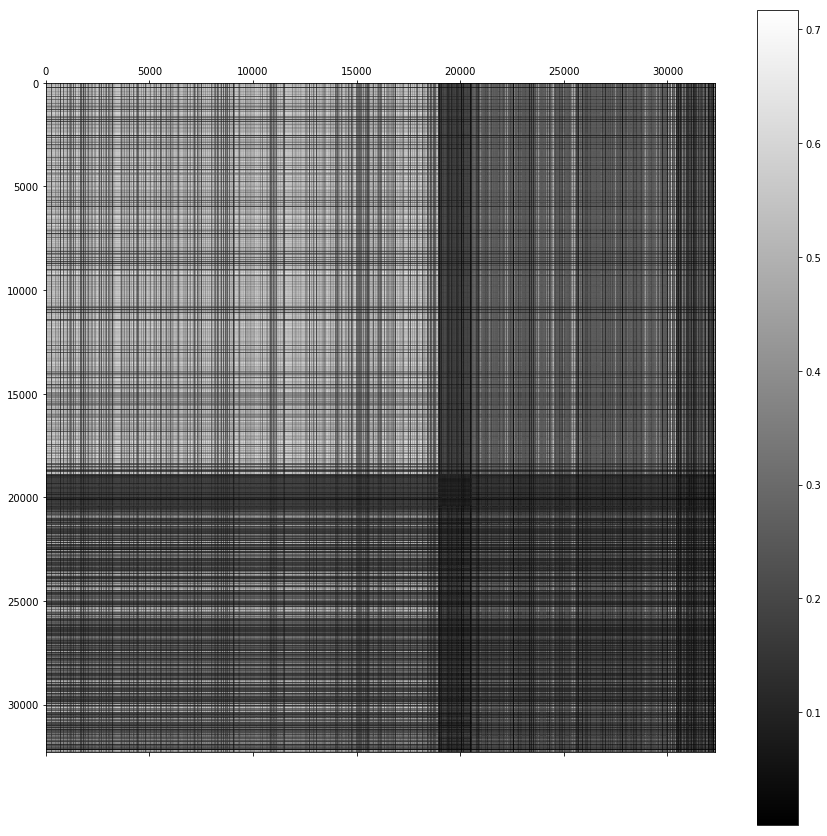

In [10]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=generator.node_list, beta=5.0))

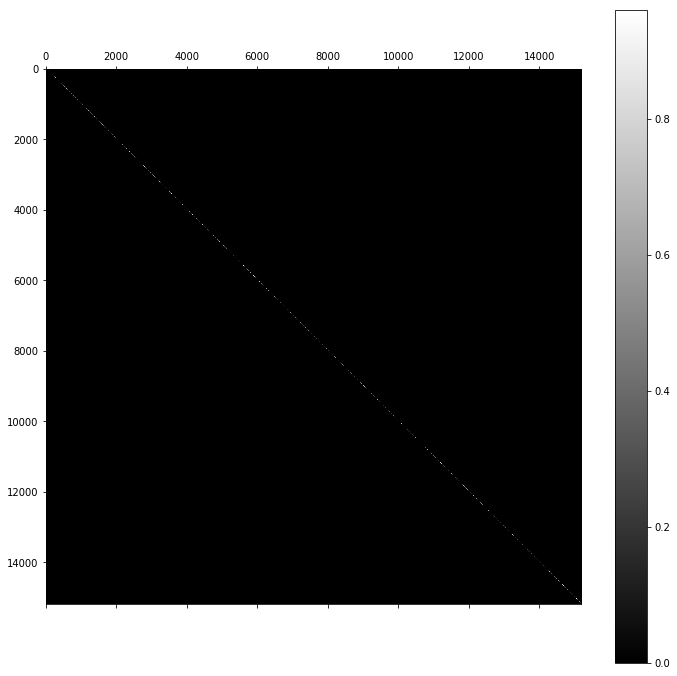

In [8]:
matrix_heatmap(node2vec_emb.get_reconstructed_adj(node_l=generator.node_list))

# Node Annotation prediction

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

method = node2vec_emb
embs = node2vec_emb.get_embedding()

label_name = "Family" # Family, Disease association, locus_type
nodes_with_label = network.genes_info[network.genes_info[label_name].notna()].index
nodelist = [node for node in nodes_with_label if node in method.node_list]
# labels = generator.genes_info.loc[nodelist, label_name].str.split("|")

labels = network.genes_info.loc[nodelist, label_name].str.split("|", expand=False)
labeler = MultiLabelBinarizer()

y = labeler.fit_transform(labels.tolist())
# y =labels
X = embs[[method.node_list.index(node) for node in nodelist]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print(X.shape, y.shape)
print(labeler.classes_)

(14324, 128) (14324, 2317)
[' m6A methyltransferase complex'
 '1-acylglycerol-3-phosphate O-acyltransferases'
 '14-3-3 phospho-serine/phospho-threonine binding proteins' ...
 'tRNA splicing ligase complex' 'tRNA-splicing endonuclease subunits'
 'tri-snRP complex']


In [28]:
y.sum(axis=1).max()

1

In [ ]:
from sklearn import svm
from sklearn.linear_model import RidgeClassifierCV, MultiTaskLasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = svm.LinearSVC(multi_class="crammer_singer")
# clf = MLPClassifier(hidden_layer_sizes=(1000,100), activation="logistic", early_stopping=True, verbose=True)
# clf = DecisionTreeClassifier()
# clf = KNeighborsClassifier(n_neighbors=50, weights="distance", algorithm="auto", metric="euclidean")

# run grid search
# param_grid = {"n_neighbors": [2, 5, 7, 10, 25, 50],
#               "weights": ["uniform", "distance"]}

# grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)

# grid_search.fit(X, y)

# print(grid_search.best_params_)

clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, classification_report
average = "micro"
# print(f1_score(y_test, clf.predict(X_test), pos_label=1, average=average))

# print(classification_report(labeler.inverse_transform(y_test), 
#                             labeler.inverse_transform(y_pred), 
#                             labels=pd.Series(labeler.classes_).str[0:20]))

print(classification_report(y_test, 
                            y_pred, 
                            labels=pd.Series(labeler.classes_).str[0:20]))

# Get top-k predicted edges for lung cancer associated lncRNAs

In [154]:
LNC = network.multi_omics_data.LNC.get_genes_info()

In [155]:
lung_lncRNAs = LNC[LNC["Disease association"].notnull() & LNC["Disease association"].str.contains("lung")].index.tolist()

In [150]:
lung_lncRNAs_nodes = list(set([v for u,v in network.G.edges(lung_lncRNAs)] + [u for u,v in network.G.edges(lung_lncRNAs)]))
lung_lncRNAs_nodes

['AC005775.1',
 'ENSG00000255354',
 'AL021878.2',
 'KCNAB1-AS2',
 'AC069228.1',
 'AP000569.1',
 'Z82196.2',
 'SBF2-AS1',
 'AC005540.3',
 'AC126335.1',
 'AC103853.1',
 'hsa-mir-4273',
 'hsa-mir-4758',
 'AL607028.1',
 'RP4-798A10.2',
 'twist',
 'HoxA13',
 'AL590422.1',
 'AL445483.1',
 'AC134978.1',
 'DENND5B-AS1',
 'AC103957.2',
 'AL020997.2',
 'SNAP47-AS1',
 'SNHG7',
 'AC127894.1',
 'RP11-849F2.9',
 'LHX5-AS1',
 'AC068944.1',
 'AC087269.1',
 'AC016168.2',
 'COX10-AS1',
 'RP1-68D18.2',
 'AC016382.1',
 'hsa-mir-377',
 'AL356361.2',
 'AC010486.2',
 'Claudin1',
 'CASP3',
 'CTC-558O2.1',
 'AC004865.2',
 'LINC01996',
 'USP2-AS1',
 'AC087439.2',
 'AL354733.1',
 'ZNF32-AS2',
 'AL121906.1',
 'AL831784.1',
 'RP11-255P5.2',
 'LINC00964',
 'AC093159.1',
 'RP11-232M24.1',
 'EGOT',
 'C5orf66-AS1',
 'AL390786.1',
 'SRGAP3-AS2',
 'AC244035.1',
 'hsa-mir-4436b',
 'D21S2088E',
 'hsa-mir-429',
 'hsa-mir-548e',
 'LINC02180',
 'ENSG00000270168',
 'AC008746.12',
 'hsa-mir-589',
 'RP11-662M24.1',
 'AC131902.2

In [168]:
top_k_pred_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                                     node_list=lung_lncRNAs_nodes,
                                                    remove_training_edges=True)

Embeddings filtered by node list (2015, 128)


In [169]:
top_k_pred_edges = [(u,v) for u,v,w in top_k_pred_edges if (u in siamese.node_list and v in siamese.node_list)]
len(top_k_pred_edges)

39

# Visualize Embeddings

In [181]:
from sklearn.metrics.pairwise import pairwise_distances
from moge.visualization.plot_data import matrix_heatmap
from scipy import sparse
# from sklearn.manifold import TSNE
from moge.visualization.visualize_embedding import get_node_color, plot_embedding2D
import matplotlib.pyplot as plt

In [182]:
from sklearn.decomposition import PCA

embs_pca = PCA(n_components=2).fit_transform(embs)

In [183]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(init=embs_pca, perplexity=80, n_jobs=8, verbose=True)
node_pos = tsne.fit_transform(embs)

In [36]:
g = network.G.subgraph(generator.node_list)
# g = nx.relabel.relabel_nodes(g, {k: v for v, k in enumerate(generator.node_list)})

In [189]:
generator.genes_info["locus_type"]

A1BG                                 protein_coding
A1CF                                 protein_coding
A2M                            processed_transcript
A2ML1                       nonsense_mediated_decay
A4GALT                         processed_transcript
A4GNT                                protein_coding
AAAS                                retained_intron
AACS                           processed_transcript
AACSP1           transcribed_unprocessed_pseudogene
AADAC                                protein_coding
AADACL2                              protein_coding
AADACL3                              protein_coding
AADACL4                              protein_coding
AADAT                                protein_coding
AAGAB                          processed_transcript
AAK1                           processed_transcript
AAMDC                       nonsense_mediated_decay
AAMP                                retained_intron
AANAT                                protein_coding
AAR2        

In [184]:
nodelist = generator.genes_info[generator.genes_info["Transcript sequence"].notnull()][
    generator.genes_info["locus_type"].isin([\
                                             "RNA, micro", 
                                             "lincRNA", 
                                             "sense_intronic"
                                             "protein_coding"
                                            ])].index.tolist()
nodelist = method.node_list
# nodelist = lung_lncRNAs
# nodelist = network_test.node_list
nodelist = [node for node in nodelist if node in method.node_list]
len(nodelist)

19532

In [191]:
edgelist = [(u,v) for u, v, d in network_test.G.edges(data=True) if (d["type"]=="d" and (u in nodelist and v in nodelist))]
np.random.shuffle(edgelist)
len(edgelist)

525651

In [187]:
node_labels = generator.genes_info.loc[nodelist]["locus_type"].astype(str) # "Transcript length", "locus_type", "Family"
sorted_node_labels = sorted(node_labels.unique(), reverse=True)
node_colormap = {f:sorted_node_labels.index(f)/len(sorted_node_labels) for f in node_labels.unique()}
node_colors = [node_colormap[n] if n in node_colormap.keys() else None for n in node_labels]      

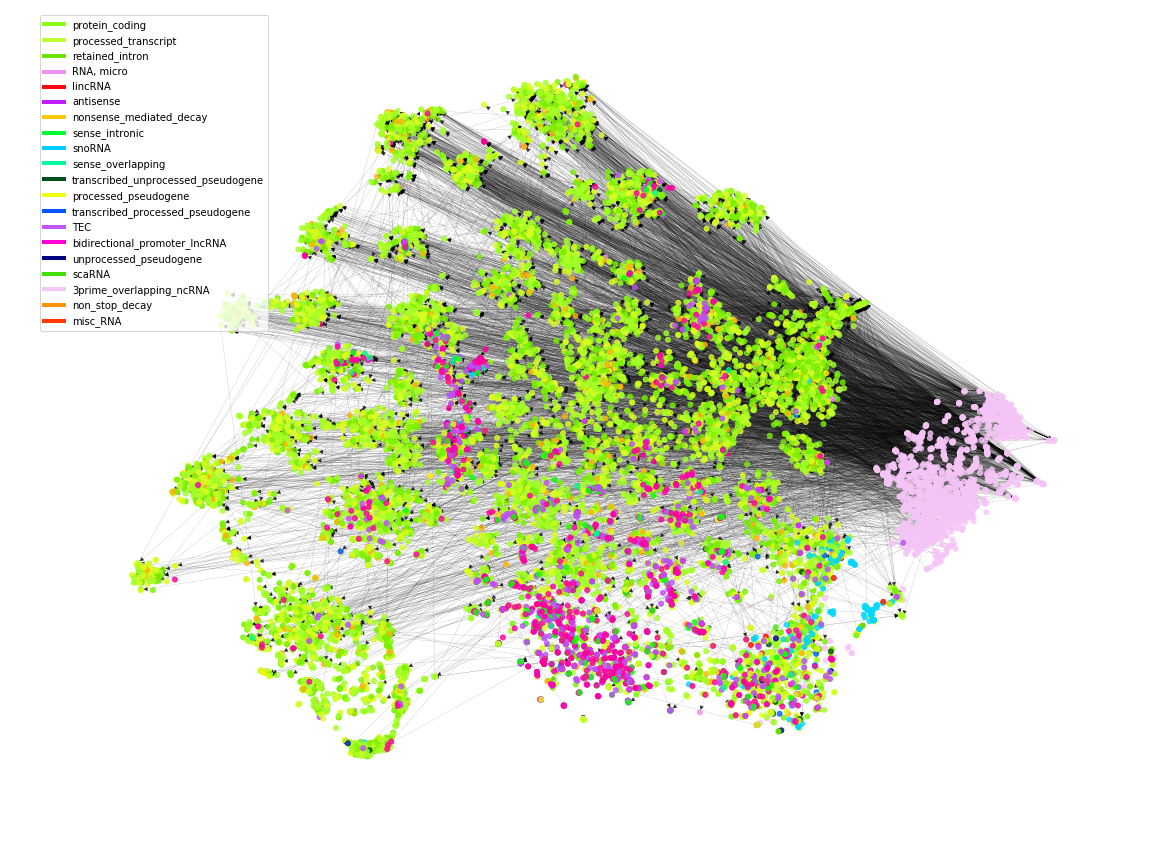

In [192]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

plot_embedding2D(node_pos, node_list=method.node_list, node_colors=node_colors,
                 legend=True, node_labels=node_labels, node_colormap=node_colormap, legend_size=20,
                 di_graph=g, cmap="gist_ncar", nodelist=nodelist,
                 plot_nodes_only=False, edgelist=edgelist[0:5000], 
                 with_labels=False, figsize=(20,15),
#                  file_name="moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf"
                )


In [59]:
plt.savefig("moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf")

<Figure size 432x288 with 0 Axes>